# Fast.ai on SageMaker example

With Amazon SageMaker, you can package your own algorithms that can then be trained and deployed in the SageMaker environment. This notebook guides you through an example on how to extend one of our existing and predefined SageMaker deep learning framework containers.

By packaging an algorithm in a container, you can bring almost any code to the Amazon SageMaker environment, regardless of programming language, environment, framework, or dependencies. 

1. [Extending our PyTorch containers](#Extending-our-pytorch-containers)
  1. [When should I extend a SageMaker container?](#When-should-I-extend-a-SageMaker-container?)
  1. [Permissions](#Permissions)
  1. [The example](#The-example)
  1. [The presentation](#The-presentation)
1. [Part 1: Packaging and Uploading your Algorithm for use with Amazon SageMaker](#Part-1:-Packaging-and-Uploading-your-Algorithm-for-use-with-Amazon-SageMaker)
    1. [An overview of Docker](#An-overview-of-Docker)
    1. [How Amazon SageMaker runs your Docker container](#How-Amazon-SageMaker-runs-your-Docker-container)
      1. [Running your container during training](#Running-your-container-during-training)
        1. [The input](#The-input)
        1. [The output](#The-output)
      1. [Running your container during hosting](#Running-your-container-during-hosting)
    1. [The parts of the sample container](#The-parts-of-the-sample-container)
    1. [The Dockerfile](#The-Dockerfile)
    1. [Building and registering the container](#Building-and-registering-the-container)
  1. [Testing your algorithm on your local machine](#Testing-your-algorithm-on-your-local-machine)
  1. [Download the CIFAR-10 dataset](#Download-the-CIFAR-10-dataset)
  1. [SageMaker Python SDK Local Training](#SageMaker-Python-SDK-Local-Training)
  1. [Fit, Deploy, Predict](#Fit,-Deploy,-Predict)
  1. [Making predictions using Python SDK](#Making-predictions-using-Python-SDK)
1. [Part 2: Training and Hosting your Algorithm in Amazon SageMaker](#Part-2:-Training-and-Hosting-your-Algorithm-in-Amazon-SageMaker)
  1. [Set up the environment](#Set-up-the-environment)
  1. [Create the session](#Create-the-session)
  1. [Upload the data for training](#Upload-the-data-for-training)
  1. [Training On SageMaker](#Training-on-SageMaker)
  1. [Optional cleanup](#Optional-cleanup)  
1. [Reference](#Reference)

_or_ I'm impatient, just [let me see the code](#The-Dockerfile)!

## When should I extend a SageMaker container?

You may not need to create a container to bring your own code to Amazon SageMaker. When you are using a framework such as [TensorFlow](https://github.com/aws/sagemaker-tensorflow-container), [MXNet](https://github.com/aws/sagemaker-mxnet-container), [PyTorch](https://github.com/aws/sagemaker-pytorch-container) or [Chainer](https://github.com/aws/sagemaker-chainer-container) that has direct support in SageMaker, you can simply supply the Python code that implements your algorithm using the SDK entry points for that framework.

Even if there is direct SDK support for your environment or framework, you may want to add additional functionality or configure your container environment differently while utilizing our container to use on SageMaker.

**Some of the reasons to extend a SageMaker deep learning framework container are:**
1. Install additional dependencies. (E.g. I want to install a specific Python library, that the current SageMaker containers don't install.)
2. Configure your environment. (E.g. I want to add an environment variable to my container.)


## Permissions

Running this notebook requires permissions in addition to the normal `SageMakerFullAccess` permissions. This is because it creates new repositories in Amazon ECR. The easiest way to add these permissions is simply to add the managed policy `AmazonEC2ContainerRegistryFullAccess` to the role that you used to start your notebook instance. There's no need to restart your notebook instance when you do this, the new permissions will be available immediately.

## The example

In this example we show how to package a Fast.ai container, extending an example Fast.ai container, with a Python example which works with the [Dogscats Kaggle dataset](https://www.kaggle.com/c/dogs-vs-cats). By extending the SageMaker Fast.ai container we can utilize the existing training and hosting solution made to work on SageMaker. By comparison, if one were to build their own custom framework container from scratch, they would need to implement a training and hosting solution in order to use SageMaker. Here is an example showing [how to create a SageMaker TensorFlow container from scratch](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/advanced_functionality/tensorflow_bring_your_own/tensorflow_bring_your_own.ipynb).

In this example, we use a single image to support training and hosting. This simplifies the procedure because we only need to manage one image for both tasks. Sometimes you may want separate images for training and hosting because they have different requirements. In this case, separate the parts discussed below into separate Dockerfiles and build two images. Choosing whether to use a single image or two images is a matter of what is most convenient for you to develop and manage.

If you're only using Amazon SageMaker for training or hosting, but not both, only the functionality used needs to be built into your container.

## The presentation

This presentation is divided into two parts: _building_ the container and _using_ the container.

# Part 1: Packaging and Uploading your Algorithm for use with Amazon SageMaker

### An overview of Docker

If you're familiar with Docker already, you can skip ahead to the next section.

For many data scientists, Docker containers are a new technology. But they are not difficult and can significantly simplify the deployment of your software packages. 

Docker provides a simple way to package arbitrary code into an _image_ that is totally self-contained. Once you have an image, you can use Docker to run a _container_ based on that image. Running a container is just like running a program on the machine except that the container creates a fully self-contained environment for the program to run. Containers are isolated from each other and from the host environment, so the way your program is set up is the way it runs, no matter where you run it.

Docker is more powerful than environment managers like conda or virtualenv because (a) it is completely language independent and (b) it comprises your whole operating environment, including startup commands, and environment variable.

A Docker container is like a virtual machine, but it is much lighter weight. For example, a program running in a container can start in less than a second and many containers can run simultaneously on the same physical or virtual machine instance.

Docker uses a simple file called a `Dockerfile` to specify how the image is assembled. An example is provided below. You can build your Docker images based on Docker images built by yourself or by others, which can simplify things quite a bit.

Docker has become very popular in programming and devops communities due to its flexibility and its well-defined specification of how code can be run in its containers. It is the underpinning of many services built in the past few years, such as [Amazon ECS].

Amazon SageMaker uses Docker to allow users to train and deploy arbitrary algorithms.

In Amazon SageMaker, Docker containers are invoked in a one way for training and another, slightly different, way for hosting. The following sections outline how to build containers for the SageMaker environment.

Some helpful links:

* [Docker home page](http://www.docker.com)
* [Getting started with Docker](https://docs.docker.com/get-started/)
* [Dockerfile reference](https://docs.docker.com/engine/reference/builder/)
* [`docker run` reference](https://docs.docker.com/engine/reference/run/)

[Amazon ECS]: https://aws.amazon.com/ecs/

### How Amazon SageMaker runs your Docker container

Because you can run the same image in training or hosting, Amazon SageMaker runs your container with the argument `train` or `serve`. How your container processes this argument depends on the container. All SageMaker deep learning framework containers already cover this requirement and will trigger your defined training algorithm and inference code.

* If you specify a program as an `ENTRYPOINT` in the Dockerfile, that program will be run at startup and its first argument will be `train` or `serve`. The program can then look at that argument and decide what to do. The original `ENTRYPOINT` specified within the SageMaker PyTorch is [here](https://github.com/aws/sagemaker-pytorch-container/blob/master/docker/0.4.0/final/Dockerfile.cpu#L18).

#### Running your container during training

Currently, our SageMaker PyTorch container utilizes [console_scripts](http://python-packaging.readthedocs.io/en/latest/command-line-scripts.html#the-console-scripts-entry-point) to make use of the `train` command issued at training time. The line that gets invoked during `train` is defined within the setup.py file inside [SageMaker Containers](https://github.com/aws/sagemaker-containers/blob/master/setup.py#L48), our common SageMaker deep learning container framework. When this command is run, it will invoke the [trainer class](https://github.com/aws/sagemaker-containers/blob/master/src/sagemaker_containers/cli/train.py) to run, which will finally invoke our [PyTorch container code](https://github.com/aws/sagemaker-pytorch-container/blob/master/src/sagemaker_pytorch_container/training.py) to run your Python file.

A number of files are laid out for your use, under the `/opt/ml` directory:

    /opt/ml
    ├── input
    │   ├── config
    │   │   ├── hyperparameters.json
    │   │   └── resourceConfig.json
    │   └── data
    │       └── <channel_name>
    │           └── <input data>
    ├── model
    │   └── <model files>
    └── output
        └── failure

##### The input

* `/opt/ml/input/config` contains information to control how your program runs. `hyperparameters.json` is a JSON-formatted dictionary of hyperparameter names to values. These values are always strings, so you may need to convert them. `resourceConfig.json` is a JSON-formatted file that describes the network layout used for distributed training.
* `/opt/ml/input/data/<channel_name>/` (for File mode) contains the input data for that channel. The channels are created based on the call to CreateTrainingJob but it's generally important that channels match algorithm expectations. The files for each channel are copied from S3 to this directory, preserving the tree structure indicated by the S3 key structure. 
* `/opt/ml/input/data/<channel_name>_<epoch_number>` (for Pipe mode) is the pipe for a given epoch. Epochs start at zero and go up by one each time you read them. There is no limit to the number of epochs that you can run, but you must close each pipe before reading the next epoch.

##### The output

* `/opt/ml/model/` is the directory where you write the model that your algorithm generates. Your model can be in any format that you want. It can be a single file or a whole directory tree. SageMaker packages any files in this directory into a compressed tar archive file. This file is made available at the S3 location returned in the `DescribeTrainingJob` result.
* `/opt/ml/output` is a directory where the algorithm can write a file `failure` that describes why the job failed. The contents of this file are returned in the `FailureReason` field of the `DescribeTrainingJob` result. For jobs that succeed, there is no reason to write this file as it is ignored.

#### Running your container during hosting

Hosting has a very different model than training because hosting is reponding to inference requests that come in via HTTP. Currently, the SageMaker PyTorch containers [uses](https://github.com/aws/sagemaker-pytorch-container/blob/master/src/sagemaker_pytorch_container/serving.py#L103) our [recommended Python serving stack](https://github.com/aws/sagemaker-containers/blob/master/src/sagemaker_containers/_server.py#L44) to provide robust and scalable serving of inference requests:

![Request serving stack](stack.png)

Amazon SageMaker uses two URLs in the container:

* `/ping` receives `GET` requests from the infrastructure. Your program returns 200 if the container is up and accepting requests.
* `/invocations` is the endpoint that receives client inference `POST` requests. The format of the request and the response is up to the algorithm. If the client supplied `ContentType` and `Accept` headers, these are passed in as well. 

The container has the model files in the same place that they were written to during training:

    /opt/ml
    └── model
        └── <model files>



### The parts of the sample container

The `container` directory has all the components you need to extend the SageMaker PyTorch container to use as an sample algorithm:

    .
    ├── Dockerfile
    ├── build_and_push.sh
    └── lesson1
        ├── lesson1.py

Let's discuss each of these in turn:

* __`Dockerfile`__ describes how to build your Docker container image. More details are provided below.
* __`build_and_push.sh`__ is a script that uses the Dockerfile to build your container images and then pushes it to ECR. We invoke the commands directly later in this notebook, but you can just copy and run the script for your own algorithms.
* __`lesson1`__ is the directory which contains our user code to be invoked.

In this simple application, we install only one file in the container. You may only need that many, but if you have many supporting routines, you may wish to install more.

The files that we put in the container are:

* __`lesson1.py`__ is the program that implements our training algorithm and handles loading our model for inferences.

### The Dockerfile

The Dockerfile describes the image that we want to build. You can think of it as describing the complete operating system installation of the system that you want to run. A Docker container running is quite a bit lighter than a full operating system, however, because it takes advantage of Linux on the host machine for the basic operations. 

We start from the SageMaker Fast.ai image as the base. The base image is an ECR image, so it will have the following pattern.
* {account}.dkr.ecr.{region}.amazonaws.com/sagemaker-{framework}:{framework_version}-{processor_type}-{python_version}

Here is an explanation of each field.
1. account - AWS account ID the ECR image belongs to. Our public deep learning framework images are all under the 520713654638 account.
2. region - The region the ECR image belongs to. [Available regions](https://aws.amazon.com/about-aws/global-infrastructure/regional-product-services/).
3. framework - The deep learning framework.
4. framework_version - The version of the deep learning framework.
5. processor_type - CPU or GPU.
6. python_version - The supported version of Python.

So the SageMaker PyTorch ECR image would be:
520713654638.dkr.ecr.us-west-2.amazonaws.com/sagemaker-pytorch:0.4.0-cpu-py3

Next, we add the code that implements our specific algorithm to the container and set up the right environment for it to run under.

Finally, we need to specify two environment variables.
1. SAGEMAKER_SUBMIT_DIRECTORY - the directory within the container containing our Python script for training and inference.
2. SAGEMAKER_PROGRAM - the Python script that should be invoked for training and inference.

Let's look at the Dockerfile for this example.

In [ ]:
!cat container/Dockerfile

### Building and registering the container

The following shell code shows how to build the container image using `docker build` and push the container image to ECR using `docker push`. This code is also available as the shell script `container/build-and-push.sh`, which you can run as `build-and-push.sh pytorch-extending-our-containers-cifar10-example` to build the image `pytorch-extending-our-containers-cifar10-example`. 

This code looks for an ECR repository in the account you're using and the current default region (if you're using a SageMaker notebook instance, this is the region where the notebook instance was created). If the repository doesn't exist, the script will create it. In addition, since we are using the SageMaker PyTorch image as the base, we will need to retrieve ECR credentials to pull this public image.

In [ ]:
%%sh

# The name of our algorithm
algorithm_name=fastai-lesson1-example

cd container

account=$(aws sts get-caller-identity --query Account --output text)

# Get the region defined in the current configuration (default to us-west-2 if none defined)
region=$(aws configure get region)
region=${region:-eu-west-1}

fullname="${account}.dkr.ecr.${region}.amazonaws.com/${algorithm_name}:latest"

# If the repository doesn't exist in ECR, create it.

aws ecr describe-repositories --repository-names "${algorithm_name}" > /dev/null 2>&1

if [ $? -ne 0 ]
then
    aws ecr create-repository --repository-name "${algorithm_name}" > /dev/null
fi

# Get the login command from ECR and execute it directly
$(aws ecr get-login --region ${region} --no-include-email)

# Get the login command from ECR in order to pull down the SageMaker PyTorch image
$(aws ecr get-login --registry-ids 934676248949 --region ${region} --no-include-email)

# Build the docker image locally with the image name and then push it to ECR
# with the full name.

docker build  -t ${algorithm_name} .
docker tag ${algorithm_name} ${fullname}

docker push ${fullname}

## Testing your algorithm on your local machine

When you're packaging your first algorithm to use with Amazon SageMaker, you probably want to test it yourself to make sure it's working correctly. We use the [SageMaker Python SDK](https://github.com/aws/sagemaker-python-sdk) to test both locally and on SageMaker. For more examples with the SageMaker Python SDK, see [Amazon SageMaker Examples](https://github.com/awslabs/amazon-sagemaker-examples/tree/master/sagemaker-python-sdk). In order to test our algorithm, we need our dataset.

## Download the DogsCats dataset
We will be utilizing the dogscats data for training.

In [7]:
DOGSCATS_DATA_PATH='/tmp/data/dogscats/'
UPLOAD_DATA_PATH='/tmp/data_upload/dogscats/'

In [ ]:
%mkdir /tmp/data
! wget -P /tmp/data http://files.fast.ai/data/dogscats.zip
! unzip -q -d /tmp/data /tmp/data/dogscats.zip
! rm /tmp/data/dogscats.zip
%mkdir -p {UPLOAD_DATA_PATH}
%cp -R {DOGSCATS_DATA_PATH}train {UPLOAD_DATA_PATH}train
%cp -R {DOGSCATS_DATA_PATH}train {UPLOAD_DATA_PATH}valid

In [2]:
! ls {DOGSCATS_DATA_PATH}

models	sample	test1  tmp  train  valid


## SageMaker Python SDK Local Training
To represent our training, we use the Estimator class, which needs to be configured in five steps. 
1. IAM role - our AWS execution role
2. train_instance_count - number of instances to use for training.
3. train_instance_type - type of instance to use for training. For training locally, we specify `local` or `local_gpu`.
4. image_name - our custom PyTorch Docker image we created.
5. hyperparameters - hyperparameters we want to pass.

Let's start with setting up our IAM role. We make use of a helper function within the Python SDK. This function throw an exception if run outside of a SageMaker notebook instance, as it gets metadata from the notebook instance. If running outside, you must provide an IAM role with proper access stated above in [Permissions](#Permissions).

In [ ]:
#from sagemaker import get_execution_role

#role = get_execution_role()

## Fit, Deploy, Predict

Now that the rest of our estimator is configured, we can call `fit()` with the path to our local CIFAR10 dataset prefixed with `file://`. This invokes our PyTorch container with 'train' and passes in our hyperparameters and other metadata as json files in /opt/ml/input/config within the container to our program entry point defined in the Dockerfile.

After our training has succeeded, our training algorithm outputs our trained model within the /opt/ml/model directory, which is used to handle predictions.

We can then call `deploy()` with an instance_count and instance_type, which is 1 and `local`. This invokes our PyTorch container with 'serve', which setups our container to handle prediction requests as defined [here](https://github.com/aws/sagemaker-pytorch-container/blob/master/src/sagemaker_pytorch_container/serving.py#L103). What is returned is a predictor, which is used to make inferences against our trained model.

After our prediction, we can delete our endpoint.

We recommend testing and training your training algorithm locally first, as it provides quicker iterations and better debuggability.

In [ ]:
# Lets set up our SageMaker notebook instance for local mode.
!/bin/bash ./utils/setup.sh

In [3]:
role = 'arn:aws:iam::934676248949:role/service-role/AmazonSageMaker-ExecutionRole-20171203T194740'

In [4]:
import os
import subprocess

instance_type = 'local'

if subprocess.call('nvidia-smi') == 0:
    ## Set type to GPU if one is present
    instance_type = 'local_gpu'
    
print("Instance type = " + instance_type)

Instance type = local_gpu


In [11]:
from sagemaker.estimator import Estimator

hyperparameters = {'epochs': 1, 'batch-size': 128}

estimator = Estimator(role=role,
                      train_instance_count=1,
                      train_instance_type=instance_type,
                      image_name='fastai-lesson1-example:latest',
                      hyperparameters=hyperparameters)

estimator.fit(f'file://{DOGSCATS_DATA_PATH}')

INFO:sagemaker:Creating training-job with name: fastai-lesson1-example-2018-09-03-21-32-53-419


Attaching to tmpk8ddtb6u_algo-1-C0IKN_1
/home/ec2-user/anaconda3/lib/python3.6/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.23) or chardet (3.0.4) doesn't match a supported version!
algo-1-C0IKN_1  | 2018-09-03 21:32:55,955 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
  RequestsDependencyWarning)
algo-1-C0IKN_1  | 2018-09-03 21:32:55,970 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
Creating tmpk8ddtb6u_algo-1-C0IKN_1 ... 
algo-1-C0IKN_1  | 2018-09-03 21:32:55,973 sagemaker_pytorch_container.training INFO     Invoking user training script.
algo-1-C0IKN_1  | 2018-09-03 21:32:55,974 sagemaker-containers INFO     Module lesson1 does not provide a setup.py. 
algo-1-C0IKN_1  | Generating setup.py
algo-1-C0IKN_1  | 2018-09-03 21:32:55,974 sagemaker-containers INFO     Generating setup.cfg
algo-1-C0IKN_1  | 2018-09-03 21:32:55,975 sagemaker-containers INFO     Generating MANIFEST

algo-1-C0IKN_1  | Installing collected packages: lesson1
algo-1-C0IKN_1  | 
algo-1-C0IKN_1  |   Removing source in /tmp/pip-install-8ky7elcd/lesson1
algo-1-C0IKN_1  | Successfully installed lesson1-1.0.0
algo-1-C0IKN_1  | Cleaning up...
algo-1-C0IKN_1  | Removed build tracker '/tmp/pip-req-tracker-waq2s1ml'
algo-1-C0IKN_1  | 2018-09-03 21:32:57,506 sagemaker-containers INFO     Invoking user script
algo-1-C0IKN_1  | 
algo-1-C0IKN_1  | Training Env:
algo-1-C0IKN_1  | 
algo-1-C0IKN_1  | {
algo-1-C0IKN_1  |     "channel_input_dirs": {
algo-1-C0IKN_1  |         "training": "/opt/ml/input/data/training"
algo-1-C0IKN_1  |     },
algo-1-C0IKN_1  |     "current_host": "algo-1-C0IKN",
algo-1-C0IKN_1  |     "framework_module": "sagemaker_pytorch_container.training:main",
algo-1-C0IKN_1  |     "hosts": [
algo-1-C0IKN_1  |         "algo-1-C0IKN"
algo-1-C0IKN_1  |     ],
algo-1-C0IKN_1  |     "hyperparameters": {
algo-1-C0IKN_1  |         "epochs": 1,
algo-1-C0IKN_1  |         "batch-size": 128
alg

## Making predictions using Python SDK

To make predictions, we will use a few images, from the test loader, converted into a json format to send as an inference request.

The reponse will be tensors containing the probabilities of each image belonging to one of the 10 classes. Based on the highest probability we will map that index to the corresponding class in our output. The classes can be referenced from the [CIFAR-10 website](https://www.cs.toronto.edu/~kriz/cifar.html). Since we didn't train the model for that long, we aren't expecting very accurate results.

In [12]:
from sagemaker.predictor import RealTimePredictor, json_deserializer

class ImagePredictor(RealTimePredictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(endpoint_name, sagemaker_session=sagemaker_session, serializer=None, 
                                            deserializer=json_deserializer, content_type='image/jpeg')

In [13]:
predictor = estimator.deploy(1, instance_type, predictor_cls=ImagePredictor)

INFO:sagemaker:Creating model with name: fastai-lesson1-example-2018-09-03-21-34-41-313
INFO:sagemaker:Creating endpoint with name fastai-lesson1-example-2018-09-03-21-32-53-419


Attaching to tmp7pjhmf1f_algo-1-OAYSK_1
/home/ec2-user/anaconda3/lib/python3.6/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.23) or chardet (3.0.4) doesn't match a supported version!
algo-1-OAYSK_1  | 2018/09/03 21:34:43 [crit] 23#23: *1 connect() to unix:/tmp/gunicorn.sock failed (2: No such file or directory) while connecting to upstream, client: 172.18.0.1, server: , request: "GET /ping HTTP/1.1", upstream: "http://unix:/tmp/gunicorn.sock:/ping", host: "localhost:8080"
  RequestsDependencyWarning)
algo-1-OAYSK_1  | 172.18.0.1 - - [03/Sep/2018:21:34:43 +0000] "GET /ping HTTP/1.1" 502 182 "-" "-"
Creating tmp7pjhmf1f_algo-1-OAYSK_1 ... 
algo-1-OAYSK_1  | [2018-09-03 21:34:43 +0000] [22] [INFO] Starting gunicorn 19.9.0
algo-1-OAYSK_1  | [2018-09-03 21:34:43 +0000] [22] [INFO] Listening at: unix:/tmp/gunicorn.sock (22)
algo-1-OAYSK_1  | [2018-09-03 21:34:43 +0000] [22] [INFO] Using worker: gevent
algo-1-OAYSK_1  | [2018-09-03 21:34:43 +0000] [33] [INFO] Bo

algo-1-OAYSK_1  | Installing collected packages: lesson1
algo-1-OAYSK_1  | 
algo-1-OAYSK_1  |   Removing source in /tmp/pip-install-una40d2_/lesson1
algo-1-OAYSK_1  | Successfully installed lesson1-1.0.0
algo-1-OAYSK_1  | Cleaning up...
algo-1-OAYSK_1  | Removed build tracker '/tmp/pip-req-tracker-h3d5o3ag'
algo-1-OAYSK_1  | /usr/local/lib/python3.6/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
algo-1-OAYSK_1  |   from numpy.core.umath_tests import inner1d
!algo-1-OAYSK_1  | 172.18.0.1 - - [03/Sep/2018:21:35:00 +0000] "GET /ping HTTP/1.1" 200 0 "-" "-"


In [14]:
import os, random
from PIL import Image

TEST_DATA_PATH=f'{DOGSCATS_DATA_PATH}/test1/'

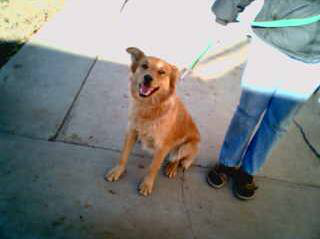

In [23]:
img_file = random.choice(os.listdir(TEST_DATA_PATH)) #change dir name to whatever
img_pil = Image.open(TEST_DATA_PATH+img_file)
img_pil

In [24]:
with open(TEST_DATA_PATH+img_file,'rb') as f:
    # Serializes data and makes a prediction request to the endpoint (local or sagemaker)
    response = predictor.predict(f.read())
    response

algo-1-OAYSK_1  | 2018-09-03 21:36:02,095 lesson1      INFO     Deserializing the input data.
algo-1-OAYSK_1  | 2018-09-03 21:36:02,095 lesson1      INFO     Processing jpeg image.
algo-1-OAYSK_1  | 2018-09-03 21:36:02,100 lesson1      INFO     Returning image as PyTorch Variable.
algo-1-OAYSK_1  | 2018-09-03 21:36:02,100 lesson1      INFO     Calling model
algo-1-OAYSK_1  | 2018-09-03 21:36:02,291 lesson1      INFO     Getting best prediction
algo-1-OAYSK_1  | 2018-09-03 21:36:02,291 lesson1      INFO     Getting class and confidence score
algo-1-OAYSK_1  | 2018-09-03 21:36:02,291 lesson1      INFO     {'class': 'dogs', 'confidence': 0.9956241250038147}
algo-1-OAYSK_1  | 2018-09-03 21:36:02,291 lesson1      INFO     Serializing the generated output.
algo-1-OAYSK_1  | 172.18.0.1 - - [03/Sep/2018:21:36:02 +0000] "POST /invocations HTTP/1.1" 200 51 "-" "-"


In [25]:
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint with name: fastai-lesson1-example-2018-09-03-21-32-53-419


Gracefully stopping... (press Ctrl+C again to force)
Stopping tmp7pjhmf1f_algo-1-OAYSK_1 ... 


# Part 2: Training and Hosting your Algorithm in Amazon SageMaker
Once you have your container packaged, you can use it to train and serve models. Let's do that with the algorithm we made above.

## Set up the environment
Here we specify the bucket to use and the role that is used for working with SageMaker.

In [ ]:
# S3 prefix
prefix = 'DEMO-fastai-dogscats'

## Create the session

The session remembers our connection parameters to SageMaker. We use it to perform all of our SageMaker operations.

In [26]:
import sagemaker as sage

sess = sage.Session()

## Upload the data for training

We will use the tools provided by the SageMaker Python SDK to upload the data to a default bucket.

In [ ]:
data_location = sess.upload_data(UPLOAD_DATA_PATH, key_prefix=prefix)

In [27]:
role = 'arn:aws:iam::934676248949:role/service-role/AmazonSageMaker-ExecutionRole-20171203T194740'

In [28]:
data_location = 's3://sagemaker-eu-west-1-934676248949/DEMO-fastai-dogscats'

## Training on SageMaker
Training a model on SageMaker with the Python SDK is done in a way that is similar to the way we trained it locally. This is done by changing our train_instance_type from `local` to one of our [supported EC2 instance types](https://aws.amazon.com/sagemaker/pricing/instance-types/).

In addition, we must now specify the ECR image URL, which we just pushed above.

Finally, our local training dataset has to be in Amazon S3 and the S3 URL to our dataset is passed into the `fit()` call.

Let's first fetch our ECR image url that corresponds to the image we just built and pushed.

In [29]:
import boto3

client = boto3.client('sts')
account = client.get_caller_identity()['Account']

my_session = boto3.session.Session()
region = my_session.region_name

algorithm_name = 'fastai-lesson1-example'

ecr_image = '{}.dkr.ecr.{}.amazonaws.com/{}:latest'.format(account, region, algorithm_name)

print(ecr_image)

934676248949.dkr.ecr.eu-west-1.amazonaws.com/fastai-lesson1-example:latest


In [30]:
from sagemaker.estimator import Estimator

hyperparameters = {'epochs': 1}

instance_type_train = 'ml.p3.2xlarge'

estimator = Estimator(role=role,
                      train_instance_count=1,
                      train_instance_type=instance_type_train,
                      train_volume_size=100,
                      image_name=ecr_image,
                      hyperparameters=hyperparameters)

estimator.fit(data_location)

INFO:sagemaker:Creating training-job with name: fastai-lesson1-example-2018-09-03-21-41-02-320


2018-09-03 21:41:03 Starting - Starting the training job............
2018-09-03 21:42:52 Downloading - Downloading input data...............
2018-09-03 21:45:19 Training - Training in-progress............
bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2018-09-03 21:47:25,308 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2018-09-03 21:47:25,326 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2018-09-03 21:47:25,934 sagemaker_pytorch_container.training INFO     Invoking user training script.
2018-09-03 21:47:25,936 sagemaker-containers INFO     Module lesson1 does not provide a setup.py. 
Generating setup.py
2018-09-03 21:47:25,936 sagemaker-containers INFO     Generating setup.cfg
2018-09-03 21:47:25,936 sagemaker-containers INFO     Generating MANIFEST.in
2018-09-03 21:47:25,936 sagemaker-containers INFO     Installing module with the followin

epoch      trn_loss   val_loss   accuracy   
    0      0.262114   0.063119   0.9865    
epoch      trn_loss   val_loss   accuracy   
    0      0.278652   0.050101   0.989     
2018-09-03 21:50:50,835 sagemaker-containers INFO     Reporting training SUCCESS

2018-09-03 21:50:52 Uploading - Uploading generated training model
2018-09-03 21:51:08 Completed - Training job completed
Billable seconds: 496


In [33]:
instance_type_deploy = 'ml.m4.xlarge'

predictor = estimator.deploy(1, instance_type_deploy, endpoint_name='fastai-lesson1-example-2018-09-03-22-10-02-320', predictor_cls=ImagePredictor)

INFO:sagemaker:Creating model with name: fastai-lesson1-example-2018-09-03-22-10-35-958
INFO:sagemaker:Creating endpoint with name fastai-lesson1-example-2018-09-03-22-10-02-320


--------------------------------------------------------------------------------------!

In [34]:
import os, random
from PIL import Image

TEST_DATA_PATH=f'{DOGSCATS_DATA_PATH}/test1/'

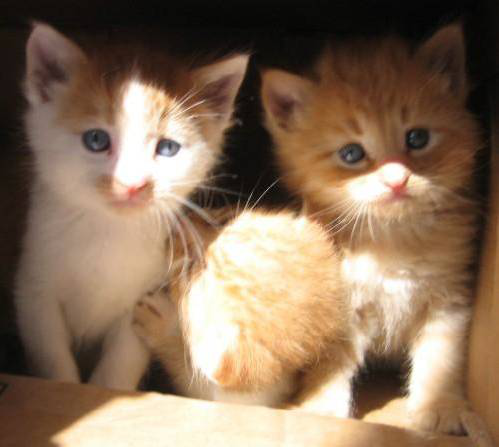

In [52]:
img_file = random.choice(os.listdir(TEST_DATA_PATH)) #change dir name to whatever
img_pil = Image.open(TEST_DATA_PATH+img_file)
img_pil

In [53]:
with open(TEST_DATA_PATH+img_file,'rb') as f:
    # Serializes data and makes a prediction request to the endpoint (local or sagemaker)
    response = predictor.predict(f.read())

print(response)

{'class': 'cats', 'confidence': 0.9848970770835876}


## Optional cleanup
When you're done with the endpoint, you should clean it up.

All of the training jobs, models and endpoints we created can be viewed through the SageMaker console of your AWS account.

In [ ]:
predictor.delete_endpoint()

# Reference
- [How Amazon SageMaker interacts with your Docker container for training](https://docs.aws.amazon.com/sagemaker/latest/dg/your-algorithms-training-algo.html)
- [How Amazon SageMaker interacts with your Docker container for inference](https://docs.aws.amazon.com/sagemaker/latest/dg/your-algorithms-inference-code.html)
- [CIFAR-10 Dataset](https://www.cs.toronto.edu/~kriz/cifar.html)
- [SageMaker Python SDK](https://github.com/aws/sagemaker-python-sdk)
- [Dockerfile](https://docs.docker.com/engine/reference/builder/)
- [scikit-bring-your-own](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/advanced_functionality/scikit_bring_your_own/scikit_bring_your_own.ipynb)
- [SageMaker PyTorch container](https://github.com/aws/sagemaker-pytorch-container)